In [1]:
import sys
import pickle
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc

sys.path.append("..")

from utils.mva_utils import (
    Ztt_inc, ttV, VV, Top, W, Zll_inc, ggH, VBFH, WH, ZH, ttH,
    calc_vars, fetch_weights, read_root, read_data_root, save_raw_data,
    apply_cuts, combine_mc_years, combine_data_years,
    Var, Data_Var, event_cleaning, get_config, ff_scale
)

cfg_run2 = get_config('run2')

/global/homes/a/agarabag/.conda/envs/ditau/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# -----------------------------
# Build weights per dataset/process
# -----------------------------

datasets = ['mc20d', 'mc20a', 'mc20e']

categories = {
    'signal': {
        'VBFH': VBFH, 'ggH': ggH, 'WH': WH, 'ZH': ZH, 'ttH': ttH,
    },
    'background': {
        'Ztt_inc': Ztt_inc, 'VV': VV, 'Top': Top,
        'W': W, 'Zll_inc': Zll_inc, 'ttV': ttV
    }
}

weights = {}
for dataset in datasets:
    weights[dataset] = {}
    for category, processes in categories.items():
        weights[dataset][category] = {}
        for process_name, process_list in processes.items():
            key = f"{process_name}_ws_{dataset[-1]}"
            weights[dataset][category][key] = fetch_weights(process_list, dataset)

Reading weights from ../data/xsec_sumofweights_nom.json
DSID 346190, year: mc20d, weight: 0.01374062646, sum: 3778941.8014208972
Reading weights from ../data/xsec_sumofweights_nom.json
DSID 346191, year: mc20d, weight: 0.01913667954, sum: 1877808.4331722963
Reading weights from ../data/xsec_sumofweights_nom.json
DSID 346192, year: mc20d, weight: 0.019130037659999998, sum: 1870228.6491911302
Reading weights from ../data/xsec_sumofweights_nom.json
DSID 346193, year: mc20d, weight: 0.0470363709, sum: 3775001.6445849
Reading weights from ../data/xsec_sumofweights_nom.json
DSID 345948, year: mc20d, weight: 0.0438977264, sum: 9398448.776731871
Reading weights from ../data/xsec_sumofweights_nom.json
DSID 345120, year: mc20d, weight: 0.1637891564, sum: 43361653.939813375
Reading weights from ../data/xsec_sumofweights_nom.json
DSID 345121, year: mc20d, weight: 0.23003485619999997, sum: 15928683.313624144
Reading weights from ../data/xsec_sumofweights_nom.json
DSID 345122, year: mc20d, weight: 0

In [ ]:
# -----------------------------
# Read MC and Data
# -----------------------------

processes = {
    'signal': {'VBFH': VBFH, 'ggH': ggH, 'WH': WH, 'ZH': ZH, 'ttH': ttH},
    'background': {'Ztt_inc': Ztt_inc, 'VV': VV, 'Top': Top, 'W': W, 'Zll_inc': Zll_inc, 'ttV': ttV}
}

total_mc = {}
for dataset in ['mc20e', 'mc20d', 'mc20a']:
    suffix = dataset[-1]
    year = cfg_run2['year_map'][dataset]
    dataset_results = {}
    for category, procs in processes.items():
        for proc_name, proc_list in procs.items():
            weight_key = f"{proc_name}_ws_{suffix}"
            weight = weights[dataset][category][weight_key]
            var_name = f"{proc_name}_{suffix}"
            dataset_results[var_name] = read_root(proc_list, weight, year_id=dataset, year=year, is_signal=(category == 'signal'), config=cfg_run2)
    total_mc[dataset] = dataset_results


data_18 = read_data_root(year='18', config=cfg_run2)
data_17 = read_data_root(year='17', config=cfg_run2)
data_16 = read_data_root(year='16', config=cfg_run2)
data_15 = read_data_root(year='15', config=cfg_run2)

# Save raw
save_raw_data(total_mc, 'MC')
save_raw_data({'data_18': data_18, 'data_17': data_17, 'data_16': data_16, 'data_15': data_15}, 'data')

In [ ]:
# -----------------------------
# Apply cuts and combine years
# -----------------------------

with open('/pscratch/sd/a/agarabag/ditdau_samples/raw_mc_run2.pkl', 'rb') as f:
    uncut_mc = pickle.load(f)
with open('/pscratch/sd/a/agarabag/ditdau_samples/raw_data_run2.pkl', 'rb') as f:
    uncut_data = pickle.load(f)

cut_data = apply_cuts({'data_18': uncut_data['data_18'], 'data_17': uncut_data['data_17'], 'data_16': uncut_data['data_16'], 'data_15': uncut_data['data_15']}, data_type='data', config=cfg_run2)
cut_mc = apply_cuts(uncut_mc, data_type='MC', config=cfg_run2)

combined_mc = combine_mc_years(cut_mc)
combines_data = combine_data_years(cut_data)

In [3]:
# -----------------------------
# Build variables and DataFrames
# -----------------------------

vbfh_cut = combined_mc['VBFH']
ggh_cut = combined_mc['ggH']
wh_cut = combined_mc['WH']
zh_cut = combined_mc['ZH']
tth_cut = combined_mc['ttH']
ztt_inc_cut = combined_mc['Ztt_inc']
ttv_cut = combined_mc['ttV']
vv_cut = combined_mc['VV']
top_cut = combined_mc['Top']
w_cut = combined_mc['W']
zll_inc_cut = combined_mc['Zll_inc']

data_cut = combines_data

ggh_plot = Var(ggh_cut)
vbfh_plot = Var(vbfh_cut)
wh_plot = Var(wh_cut)
zh_plot = Var(zh_cut)
tth_plot = Var(tth_cut)
vv_plot = Var(vv_cut)
top_plot = Var(top_cut)
ztt_plot = Var(ztt_inc_cut)
ttv_plot = Var(ttv_cut)
w_plot = Var(w_cut)
zll_plot = Var(zll_inc_cut)

ggh_plot = event_cleaning(ggh_plot)
vbfh_plot = event_cleaning(vbfh_plot)
wh_plot = event_cleaning(wh_plot)
zh_plot = event_cleaning(zh_plot)
tth_plot = event_cleaning(tth_plot)
vv_plot = event_cleaning(vv_plot)
top_plot = event_cleaning(top_plot)
ztt_plot = event_cleaning(ztt_plot)
ttv_plot = event_cleaning(ttv_plot)
w_plot = event_cleaning(w_plot)
zll_plot = event_cleaning(zll_plot)

ggh_plot = pd.DataFrame(np.array(ggh_plot).T, columns=calc_vars)
vbfh_plot = pd.DataFrame(np.array(vbfh_plot).T, columns=calc_vars)
wh_plot = pd.DataFrame(np.array(wh_plot).T, columns=calc_vars)
zh_plot = pd.DataFrame(np.array(zh_plot).T, columns=calc_vars)
tth_plot = pd.DataFrame(np.array(tth_plot).T, columns=calc_vars)
vv_plot = pd.DataFrame(np.array(vv_plot).T, columns=calc_vars)
top_plot = pd.DataFrame(np.array(top_plot).T, columns=calc_vars)
ztt_plot = pd.DataFrame(np.array(ztt_plot).T, columns=calc_vars)
ttv_plot = pd.DataFrame(np.array(ttv_plot).T, columns=calc_vars)
w_plot = pd.DataFrame(np.array(w_plot).T, columns=calc_vars)
zll_plot = pd.DataFrame(np.array(zll_plot).T, columns=calc_vars)

data_plot = Data_Var(data_cut, config=cfg_run2)
data_plot = event_cleaning(data_plot)
data_plot = pd.DataFrame(np.array(data_plot).T, columns=calc_vars)

In [5]:
# -----------------------------
# Labeling and concatenation
# -----------------------------

for df_, label in [(vbfh_plot, 1), (ggh_plot, 1), (wh_plot, 1), (zh_plot, 1), (tth_plot, 1),
                   (vv_plot, 0), (top_plot, 0), (ztt_plot, 0), (ttv_plot, 0) , (w_plot, 0), (zll_plot, 0), (data_plot, 0)]:
    df_['label'] = label

vbfh_plot['sample_type'] = 'vbfh'
ggh_plot['sample_type'] = 'ggh'
wh_plot['sample_type'] = 'wh'
zh_plot['sample_type'] = 'zh'
tth_plot['sample_type'] = 'tth'
vv_plot['sample_type'] = 'vv'
top_plot['sample_type'] = 'top'
ztt_plot['sample_type'] = 'ztt'
ttv_plot['sample_type'] = 'ttv'
w_plot['sample_type'] = 'w'
zll_plot['sample_type'] = 'zll'
data_plot['sample_type'] = 'data'

df = pd.concat([data_plot, ggh_plot, vbfh_plot, wh_plot, zh_plot, tth_plot, vv_plot, top_plot, ztt_plot, w_plot, zll_plot, ttv_plot])

training_var = [
    'ditau_pt', 'leadsubjet_pt', 'subleadsubjet_pt', 'visible_ditau_m', 'collinear_mass', 'delta_R', 'delta_phi',
    'delta_eta', 'label', 'met', 'met_sig', 'met_centrality', 'event_number', 'fake_factor', 'combined_weights', 'k_t',
    'x1', 'x2', 'sample_type', 'omni_score', 'leadsubjet_charge', 'subleadsubjet_charge', 'leadsubjet_n_core_tracks',
    'subleadsubjet_n_core_tracks', 'delta_R_lead', 'delta_eta_lead', 'delta_phi_lead', 'delta_R_sublead', 'delta_eta_sublead',
    'delta_phi_sublead', 'e_ratio_lead', 'e_ratio_sublead', 'higgs_pt', 'leadsubjet_eta', 'subleadsubjet_eta', 'ditau_eta',
    'delta_phi_met_ditau'
]

df = df[training_var]

In [6]:
#check how many rows there are with label 1 and 0
df['label'].value_counts()

label
0    659163
1     13634
Name: count, dtype: int64

In [7]:
print(df.loc[df['combined_weights'] < 0, 'combined_weights'])
print(df.loc[df['fake_factor'] < 0, 'fake_factor'])

Series([], Name: combined_weights, dtype: float64)
Series([], Name: fake_factor, dtype: float64)


In [8]:
def split_data(df):
    # Split data based on event number
    ids = df['event_number'] % 3
    #append ids to the dataframe
    df['ids'] = ids
    print("All sample Split:", len(df[ids == 0]), len(df[ids == 1]), len(df[ids == 2]), len(df[ids == 3]), len(df[ids == 4]))
    #print how many signal and background events are in each set
    print("Signal Split:", len(df[(df['label'] == 1) & (df['ids'] == 0)]), len(df[(df['label'] == 1) & (df['ids'] == 1)]), len(df[(df['label'] == 1) & (df['ids'] == 2)]), len(df[(df['label'] == 1) & (df['ids'] == 3)]), len(df[(df['label'] == 1) & (df['ids'] == 4)]))
    print("Background Split:", len(df[(df['label'] == 0) & (df['ids'] == 0)]), len(df[(df['label'] == 0) & (df['ids'] == 1)]), len(df[(df['label'] == 0) & (df['ids'] == 2)]), len(df[(df['label'] == 0) & (df['ids'] == 3)]), len(df[(df['label'] == 0) & (df['ids'] == 4)]))
    # return [df[ids == 0], df[ids == 1], df[ids == 2], df[ids == 3], df[ids == 4]]
    return [df[ids == 0], df[ids == 1], df[ids == 2]]

In [9]:
#split the data into 5 sets
df_split = split_data(df)

#print number of features in df
print(df_split[0].columns)

All sample Split: 224676 224028 224093 0 0
Signal Split: 4495 4559 4580 0 0
Background Split: 220181 219469 219513 0 0
Index(['ditau_pt', 'leadsubjet_pt', 'subleadsubjet_pt', 'visible_ditau_m',
       'collinear_mass', 'delta_R', 'delta_phi', 'delta_eta', 'label', 'met',
       'met_sig', 'met_centrality', 'event_number', 'fake_factor',
       'combined_weights', 'k_t', 'x1', 'x2', 'sample_type', 'omni_score',
       'leadsubjet_charge', 'subleadsubjet_charge', 'leadsubjet_n_core_tracks',
       'subleadsubjet_n_core_tracks', 'delta_R_lead', 'delta_eta_lead',
       'delta_phi_lead', 'delta_R_sublead', 'delta_eta_sublead',
       'delta_phi_sublead', 'e_ratio_lead', 'e_ratio_sublead', 'higgs_pt',
       'leadsubjet_eta', 'subleadsubjet_eta', 'ditau_eta',
       'delta_phi_met_ditau', 'ids'],
      dtype='object')


len X_train: 448121
len X_test: 224676
signal scaling factor:  48.033920560236346
len X_train: 448769
len X_test: 224028
signal scaling factor:  48.45112947658402
len X_train: 448704
len X_test: 224093
signal scaling factor:  48.558648111332005


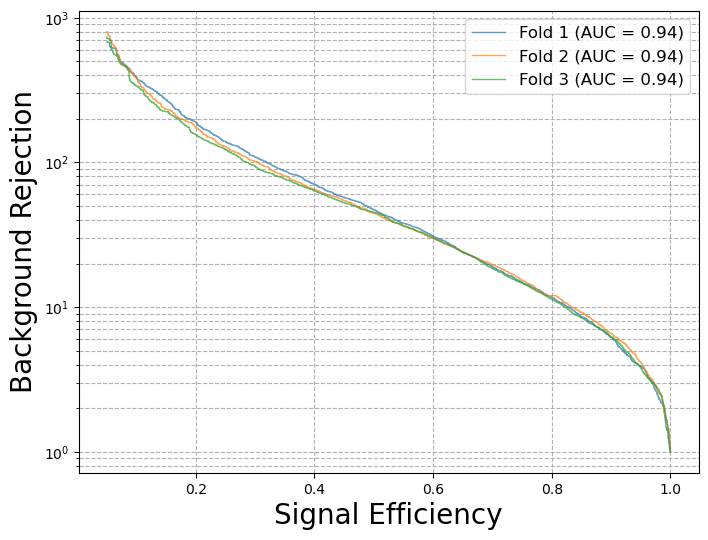

In [10]:
# models = []
signal_scores = []
background_scores = []
signal_weights = []
bkg_weghts = []

all_shap_values = []
all_feature_names = []

bdt_training_var = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10']
feature_name_mapping = {
    'leadsubjet_pt': 'f0',
    'subleadsubjet_pt': 'f1',
    'visible_ditau_m': 'f2',
    'collinear_mass': 'f3',
    'delta_R': 'f4',
    'met': 'f5',
    'met_sig': 'f6',
    'x1': 'f7',
    'x2': 'f8',
    'met_centrality': 'f9',
    'delta_phi_met_ditau': 'f10',
}

#map df_split cloumn names 
for i in range(len(df_split)):
    df_split[i] = df_split[i].rename(columns=feature_name_mapping)

# print(df_split[0])
plt.figure(figsize=(8, 6))

for i in range(len(df_split)):

    X_test = df_split[i][bdt_training_var]
    y_test = df_split[i]['label']
    evnt_w_test = df_split[i]['combined_weights']
    ff_test = df_split[i]['fake_factor']

    X_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])[bdt_training_var]
    y_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])['label']
    evnt_w_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])['combined_weights']
    ff_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])['fake_factor']

    training_weight = ff_train*evnt_w_train
    val_weights = ff_test*evnt_w_test

    # training_weight = evnt_w_train
    # val_weights = evnt_w_test

    # training_weight = np.ones(len(y_train))
    # val_weights = np.ones(len(y_test))

    # training_weight = training_weight / np.mean(training_weight)
    # val_weights = val_weights / np.mean(val_weights)

    print("len X_train:", len(X_train))
    print("len X_test:", len(X_test))

    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

    print("signal scaling factor: ", scale_pos_weight)
    
    params = {
    'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200,
    'eval_metric': 'logloss',
    'random_state': 2,
    'scale_pos_weight': scale_pos_weight,
    'base_score': 0.5,
    'objective':'binary:logistic', 
    'gamma': 0.001,
    'verbosity': 1
    }

    model = XGBClassifier(**params)
    # Train the model
    model.fit(X_train, y_train, sample_weight=training_weight)
    # models.append(model)
    booster = model.get_booster()
    booster.dump_model('xgboost_k_fold_model_{}.txt'.format(i))

    # # Calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    all_shap_values.append(shap_values)
    # Reverse the feature_name_mapping
    reversed_feature_name_mapping = {v: k for k, v in feature_name_mapping.items()}
    X_test_renamed = X_test.rename(columns=reversed_feature_name_mapping)
    all_feature_names.append(X_test_renamed.columns)
    # all_feature_names.append(X_test.columns)

    # Predict probabilities for the test set
    y_pred_proba = model.predict_proba(X_test)
    # Extract scores for signal and background
    signal_scores.extend(y_pred_proba[:, 1][y_test == 1])
    background_scores.extend(y_pred_proba[:, 1][y_test == 0])

    #add scores to df panda frame
    # df_split[i]['mva_scores'] = y_pred_proba[:, 1]

    signal_weights.extend(ff_test[y_test == 1]*-1/ff_scale)
    bkg_weghts.extend(ff_test[y_test == 0]*-1/ff_scale)

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1], sample_weight=val_weights)
    fpr = fpr[tpr > 0.05]
    tpr = tpr[tpr > 0.05]
    roc_auc = auc(fpr, tpr)
    plt.plot(tpr, 1/fpr, lw=1, alpha=0.7, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')

# plt.plot([0, 1], [0, 1], linestyle='--', color='black', lw=2, label='Random')
plt.xlabel('Signal Efficiency', fontsize=20)
plt.ylabel('Background Rejection', fontsize=20)
plt.legend(fontsize=12)
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.show()



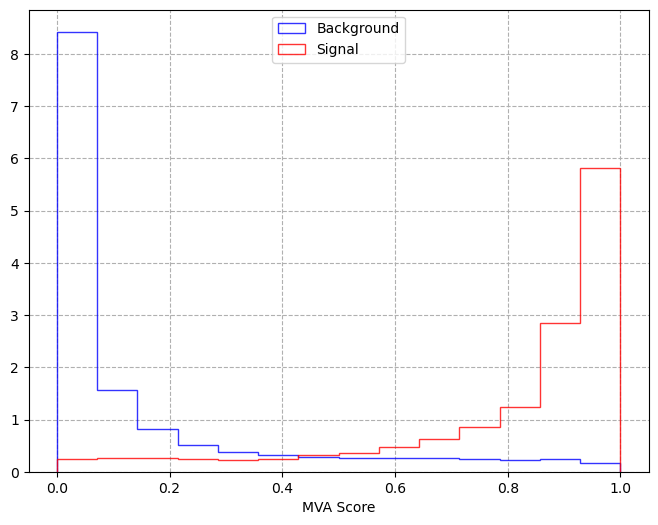

In [11]:
plt.figure(figsize=(8, 6))
plt.hist(background_scores, bins=np.linspace(0, 1, 15), alpha=0.8, color='blue', label='Background', histtype='step', density=True)
plt.hist(signal_scores, bins=np.linspace(0, 1, 15), alpha=0.8, color='red', label='Signal', histtype='step', density=True)
plt.xlabel('MVA Score')
# plt.yscale('log')
plt.legend(loc='upper center')
plt.grid(True, which="both", ls="--")
plt.show()

In [ ]:
# Aggregate SHAP values across all folds
mean_shap_values = np.mean([np.abs(shap_values).mean(0) for shap_values in all_shap_values], axis=0)
feature_names = all_feature_names[0]  # Assuming feature names are consistent across folds

# Sort features by importance
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': mean_shap_values})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance
shap.summary_plot(all_shap_values[2], X_test, plot_type="bar", feature_names=feature_names)
shap.summary_plot(all_shap_values[2], X_test, feature_names=feature_names)

# Print feature importance
print("Feature Importance Ranking:")
print(feature_importance)